# Active Contours
With no elastic and smooth energy

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from IPython.display import display, clear_output
import time
import seaborn as sns

In [2]:
dir_path ="C:/Users/gerag/Desktop/Coursera/Fisrt Principles of Computer Vision/Features and Boundaries/Active Contours/"
im_name = "tennis.png"

def plot_img(img: np.array, title: str) -> None:
    plt.title(title)
    plt.imshow(img,cmap='gray')
    plt.grid(False)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = [4, 4]
    plt.show()

def countour_plot(img: np.array, countour: np.array, title: str) -> None:
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.title(title)
    plt.imshow(img_)
    plt.plot(countour[0], countour[1], '-or')
    plt.grid(False)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = [4, 4]
    plt.show()


In [3]:
bgr_img = cv2.imread(dir_path + im_name)
#bgr_img = cv2.resize(bgr_img, (800,800), interpolation = cv2.INTER_CUBIC)
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
f,c = img.shape

### Contour Deformation greedy algorithm

1. Blur the image

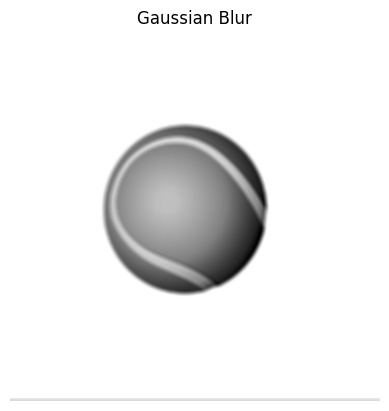

In [4]:
blurred_img = cv2.GaussianBlur(img, (15,15), sigmaX = 7.5)
plot_img(blurred_img, "Gaussian Blur")

2. Create initial contours

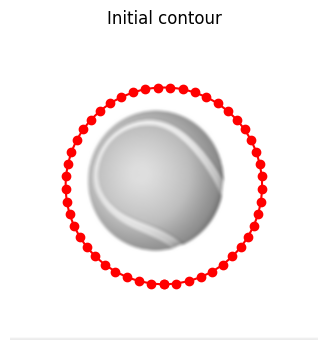

In [5]:
def create_contour(points: int,radious: int, verbose = False):
    angles = np.linspace(0, 2*pi, points)
    contours = np.asarray([c//2 + radious*np.sin(angles), f//2 + radious*np.cos(angles)], dtype='int16')
    
    if verbose:
        countour_plot(blurred_img, contours, "Initial contour")

    return contours

_ = create_contour(50,320, True)    

3. Calculate magnitude squared $ ||\nabla I||^2 $ and then calculate the blurred gradient magnitude squared $||\nabla n_\sigma \ast I||^2$

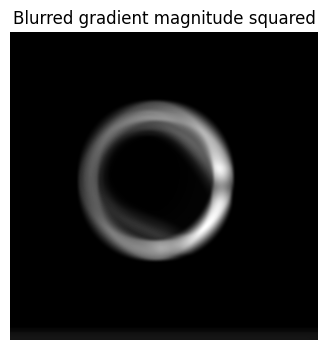

In [6]:
dx = cv2.Sobel(blurred_img, cv2.CV_64F, dx = 1, dy = 0, ksize=7)
dy = cv2.Sobel(blurred_img, cv2.CV_64F, dx = 0, dy = 1, ksize=7)

Magnitude = np.sqrt( dx**2 + dy**2 )**2 
BGMS = cv2.GaussianBlur(Magnitude, (65,65),sigmaX= 32.5)
BGMS = (BGMS - np.min(BGMS))/(np.max(BGMS)-np.min(BGMS))*255
plot_img(BGMS, "Blurred gradient magnitude squared")

4. Minimize $ E_I = - \sum_{i = 0}^{n - 1} ||\nabla I \ast I(v_i)||^2$

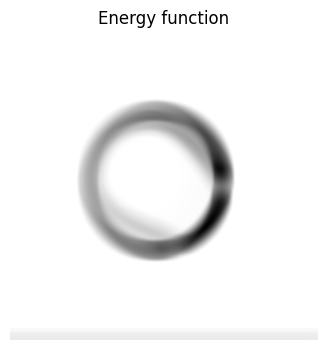

In [7]:
E_I = -np.asarray(BGMS, dtype = 'int16')
plot_img(E_I, "Energy function")

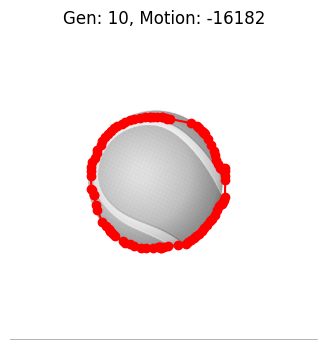

In [8]:
w_size = 7
points = 100
contour = create_contour(points, 230) #[0] = c, [1] = f

motions_sum = 0
gen = 0

while motions_sum > -16000:
    motions_sum = 0
    gen += 1
    for v in range(points):
        minimum = 10
        pos = []
        passed = False

        for i in range(-(w_size//2),(w_size//2)+1):     #f
            for j in range(-(w_size//2),(w_size//2)+1): #c
                
                if i+contour[1][v] > 0  and i+contour[1][v] < f and j+contour[0][v] > 0  and j+contour[0][v] < c:
                    
                    if E_I[i+contour[1][v]][j+contour[0][v]] < minimum and E_I[i+contour[1][v]][j+contour[0][v]] != E_I[contour[1][v]][contour[0][v]]:
                        minimum = E_I[i+contour[1][v]][j+contour[0][v]]
                        pos = [i+contour[1][v],j+contour[0][v]]
                        passed = True
                         
        if passed:
            contour[0][v] = pos[1]
            contour[1][v] = pos[0]
        motions_sum += E_I[contour[1][v]][contour[0][v]]
                        
    countour_plot(img, contour, "Gen: {}, Motion: {}".format(gen, motions_sum))
    clear_output(wait=True)
    plt.pause(0.01)